# Learning to count with a CNN

### Purpose

The purpose of this project is to test whether CNNs can be used to count objects in images. Counting can be attempted in at least two ways:
- By detection: training a CNN to detect the object of interest (using bounding boxes), and then counting the number of such detections.
- By regression: treating the number of objects in each image as the target in a regression model.

_Object Counting_ is an active area of research, however in this notebook I do not to review or implement existing research, but instead I design an experiment to thoroughly evaluate whether resnet18 can be successfully used (with transfer learning) for _counting by regression_. 

### Experiment

The images used a synthetically created. The objects that the CNN has to count in a given image are horizontal white rectangles. The background of the image is black. However, to avoid the CNN to simply correlate the count with the number of white pixels, the image has also vertical white rectangles, of the same dimension than the horizontal ones, so that the total number of rectangles is roughly constant across training images. In different images the rectangles have different areas, but the area of the rectangles remains constant within each image. The locations of the rectangles are determined at random.

### Image creation

The images are created based on 3 parameters: 

- n_obj: is the number of horizontal rectangles in the image, which also gives the label for each image.
- n_tot: is the total number of rectangles in the image: vertical and horizontal.
- r: is a real number that determines the dimension of every rectangle in the image: $2r \times 6r$ (or $6r \times 2r$).

These parameters take different values, but the images generated for testing use some values that were not used for training. This is done to evaluate the capacity of the CNN to generalize not only to images not used in training (since every image generated is unique due to randomness), but also to generalize to images generated with parameter values not used in training.

A nice property of regression models, which does not happen in classification, is that one can expect reasonable predictions for examples which labels were not available in the training set. In classification, all predictions are made with label values that at least a training example had as label. In particular, regression models could potentially generalize well to examples with labels not seen in training.

Special care is put into making the experiment and its analysis so that if the CNN succeeds at predicting the labels accurately, it is not merely due to discovering a simple pattern correlated to the number of objects, but not essential to counting. 

### Datasets

Three datasets are created: Train and Validation (the _Dev sets_), and a Test set. Train is used for the actual learning while Valid is used to track the performance during training. Both Train and Valid are generated with the same values for the image parameters. The images in Test are generated with the same values used for Dev, plus some other new values for the 3 image parameters. 

#### Dev Parameters

- n_objs = [5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 29, 30, 32, 33, 35, 36, 38, 39, 41, 42, 44, 45], available labels for images in Dev sets. 

- n_tots = [55, 65, 75], these are the possible total number of rectangles that each Dev image will have.

- r = [2.6, 2.8, 3.0, 3.2, 3.4], values for r used in Dev sets.

Images are created for all combinations of the above values, which gives at total of 420 combinations. For each combination, 14 images are created for Train, and 7 images are created for Valid, which gives roughly 6,000 images in Train, and 3,000 images in Valid. 

For example, 14 different images are created (with independently and randomly chosen locations for all their rectangles), that have n_obj=5 (i.e., 5 horizontal rectangles), n_tot=55 (i.e., 50 vertical rectangles), all of which have the same dimension given by r=2.6. There are also other 14 images with the same rectangle dimensions, and a total of 55 rectangles, but where the number of horizontal rectangles in n_obj=45, and with 10 vertical rectangles. 

In this case, the CNN will have to learn to estimate $\hat{y}=5$ for all first 14 images, and $\hat{y}=45$ for the other 14 images. Note that both sets of images have the same amount of white, and the same amount of rectangles. What does change is only the number of horizontal rectangles. This assures that the count estimation cannot merely be correlated with the number of white pixels. The CNN could act as if it were recognizing first all the horizontal rectangles, and then correlate the count estimation with their number of white pixels. But then this would imply that as r increases (and the actual count of horizontal rectangles remains constant), the count estimation should increase. Within the range of r using for training, we should that this is not the case: as r increases, the count estimation remains stable. However, outside the training range for r, the CNN behaves monotonically increasing, which shows a limitation on the capacity of the CNN to truly learn how to count.  

#### Test Parameters

- n_objs = [0, 1, 2,..., 50], all non-negative integers up to 50.

- n_tots = [50, 55, 60, 65, 70, 75, 80]

- r = [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]

### Conclusions:

- A CNN trained to counting by regression on about 6,000 images having counts of the target object (horizontal rectangle) between 5 and 45, achieves a mean absolute error of 1.4 on Test images generated with the same parameter values that the training images were generated. On 50% of the images, the estimated count has a relative error below 5.5%, and in 95% of images a relative error below to 21.3%.
- The images are created synthetically, generating horizontal and vertical white rectangles in random positions over a black background. The number of horizontal rectangles is the target variable of the regression task, while the vertical rectangles are introduced to avoid the number of white pixels to be a proxy for the count of horizontal rectangles (which would be an easy task if the images contain only the targeted horizontal rectangles).
- The training images contain a number of rectangles between 5 and 45, but only 28 of those values. However, the missing values, as well as values from 0 to 5, and from 46 to 50, are instead quantities of horizontal rectangles on testing images. The CNN shows very good generalization ability on images with those unknown-at-training label values: the MAE in this case is 1.6.
- The CNN also generalizes well to unknown values for the total number of rectangles. That is, when images have a total number of rectangles above or below the total numbers provided on training, the CNN still predicts the total number of horizontal rectangles very well: MAE for this case is 1.4.
- The CNN however shows a limitation at generalizing the ability to count horizontal rectangles when the sizes of these are different than the varying sizes using for training. This seem to suggest that the number of white pixels influences the count estimation more than it should. However, a closer analysis shows that within the rectangle size range used for training, the count of horizontal rectangles is constant with respect to the size of the rectangles. It is outside of the training range that the count estimation shows a monotonically increasing relationship with the size of the rectangles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fastai import *
from fastai.vision import *
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [2]:
''' # Required directories:
%%bash
cd /home/jupyter/.fastai/data/project3

mkdir Train
mkdir Valid
mkdir Test
mkdir tmp

'''
0

0

In [3]:
''' # Remove image files
%%bash
cd /home/jupyter/.fastai/data/project3
rm Train/*.jpg
rm Valid/*.jpg
rm Test/*.jpg

find . -type f -name "*.jpg" | wc -l
'''
0

0

#### Path to images

In [5]:
path = Path('/home/jupyter/.fastai/data/project3/')

## Synthetic image creation

In [8]:
def oneImage(n_dots, n_tot, r, dataset):
    ''' This function creates one image, with the given Image parameters, destined to the given dataset.'''
    sz = 400
    margin = 5

    img = Image.new(mode='RGB', size=(sz, sz))
    
    xs = np.random.uniform(margin, sz-margin, n_tot)
    ys = np.random.uniform(margin, sz-margin, n_tot)

    draw = ImageDraw.Draw(img)
    for k in range(n_dots):
        draw.rectangle((xs[k]-3*r, ys[k]-r, xs[k]+3*r, ys[k]+r), fill=(255, 255, 255))
    for k in np.arange(n_dots, n_tot):
        draw.rectangle((xs[k]-r, ys[k]-3*r, xs[k]+r, ys[k]+3*r), fill=(255, 255, 255))
        
    suff = (str(xs[0])[0:6]+str(ys[0])[0:6]).replace('.','')
    file_nm = 'n_'+str(n_dots)+'_t_'+str(n_tot)+'_r_'+str(r).replace('.','')+'_'+suff+'.jpg' 

    #imshow(np.asarray(img))
    
    if dataset=='tr':
        img.save(path/('Train/'+file_nm))
    elif dataset=='va':
        img.save(path/('Valid/'+file_nm)) 
    else:
        img.save(path/('Test/'+file_nm)) 

In [9]:
def manyImages(m, n_dots, n_tot, r, dataset):
    '''Creates multiple images (m), with the same parameters, but different images due to random location of rectangles.'''
    for i in range(m):
        oneImage(n_dots, n_tot, r, dataset)

## Image parameters

#### These are the possible numbers for objects to count (horizontal rectangles) in each Dev image (Train, Validation), and each Test image.

Note that the CNN will be trained using labels coming from 28 different values between 5 and 45. While testing will be done on images having label values for every possible number between 0 and 50.

In [10]:
n_objs_DEV = [5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 29, 30, 32, 33, 35, 36, 38, 39, 41, 42, 44, 45]
n_objs_TEST = range(51)

print(len(n_objs_DEV))
print(len(n_objs_TEST))

28
51


#### Possible number of total objects in each Dev image, and each Test image.

Again, the values for the Test set include values not using for training.

In [11]:
n_tots_DEV = [55, 65, 75]
n_tots_TEST = [50, 55, 60, 65, 70, 75, 80]

#### Radius in Dev sets, and in Test set.

In [12]:
r_DEV = [2.6, 2.8, 3.0, 3.2, 3.4]
r_TEST = [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]

#### Parameters for images in Dev sets: all combinations.

In [13]:
params_DEV = [[i,j,k] for i in n_objs_DEV for j in n_tots_DEV for k in r_DEV]
print(len(params_DEV))

420


#### Parameters for images in Test sets: all combinations.

In [14]:
params_TEST = [[i,j,k] for i in n_objs_TEST for j in n_tots_TEST for k in r_TEST]
print(len(params_TEST))

3927


#### Images per set: these are the desired number of images in each set (approximately).

In [22]:
n_train = 6000
n_valid = 3000
n_test = 8000

#### Determine the number of images required for each combination of parameters and for each dataset, to reach the desired numbers.

In [23]:
m_train = np.int(n_train/len(params_DEV))
m_valid = np.int(n_valid/len(params_DEV))
m_test = np.int(n_test/len(params_TEST))

print(m_train)
print(m_valid)
print(m_test)

14
7
2


## Image generation

In [24]:
make_images = False # CHANGE TO True TO CREATE THE IMAGES

In [25]:
# Images for Train
if make_images:
    for params in params_DEV:
        manyImages(m_train, params[0], params[1], params[2], 'tr')

In [26]:
# Images for Valid
if make_images:
    for params in params_DEV:
        manyImages(m_valid, params[0], params[1], params[2], 'va')

In [27]:
# Images for Test
if make_images:
    for params in params_TEST:
        manyImages(m_test, params[0], params[1], params[2], 'te')

In [28]:
%%bash
cd /home/jupyter/.fastai/data/project3

ls -l Train/ | wc -l
ls -l Valid/ | wc -l
ls -l Test/ | wc -l
find . -type f -name "*.jpg" | wc -l

5881
2941
7855
16674


## Data

In [2]:
def get_ndots(fname):
    fname = str(fname)
    return float(fname[(fname.find("n_")+2):fname.find("_t")])

In [30]:
data = (ImageItemList.from_folder(path)
        .split_by_folder(train='Train', valid='Valid')
        .label_from_func(get_ndots)
        .transform(bs=16)
        .databunch().normalize(imagenet_stats)
       )

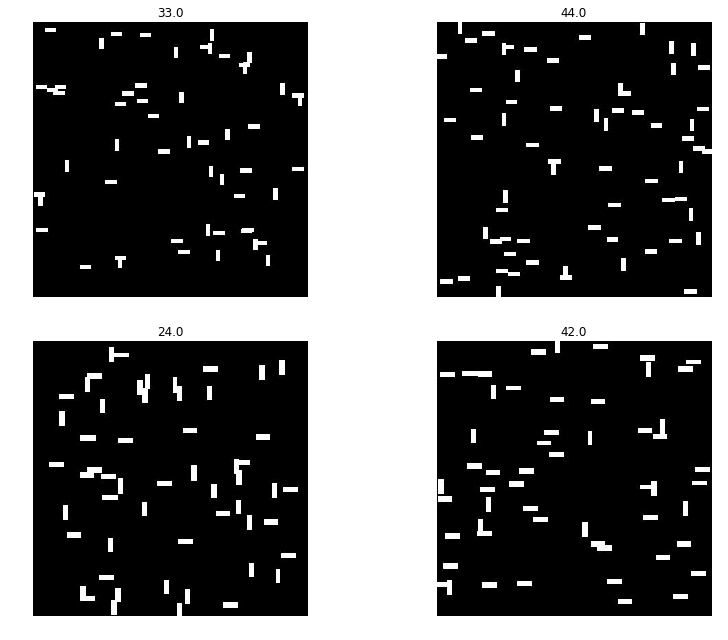

In [31]:
data.show_batch(2, figsize=(12,9))

## Train model

In [32]:
learn = create_cnn(data, models.resnet18)

In [33]:
n_epochs = 20
learn.fit_one_cycle(n_epochs)

epoch,train_loss,valid_loss
1,696.708801,640.373108
2,572.722351,442.072205
3,279.474579,52.782269
4,61.605709,10.551369
5,23.203672,8.650195
6,15.074651,7.307948
7,11.763455,6.046211
8,11.179011,5.548040
9,9.972086,4.592677
10,8.724779,4.635593


In [34]:
learn.save('counting')

### Check performance on some validation images

In [27]:
def checkValidImage(j):
    img = data.valid_ds[j][0]
    print(data.valid_ds.x.items[j])
    print('True label:', data.valid_ds[j][1])
    print('Predicted label:', learn.predict(img)[0])
    img.show(y=learn.predict(img)[0])

/home/jupyter/.fastai/data/project3/Valid/n_42_t_65_r_32_6474310626.jpg
True label: 42.0
Predicted label: 38.657249450683594


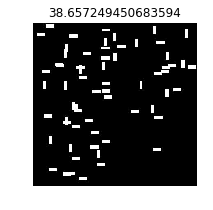

In [36]:
checkValidImage(100)

/home/jupyter/.fastai/data/project3/Valid/n_39_t_75_r_30_3144315114.jpg
True label: 39.0
Predicted label: 37.414188385009766


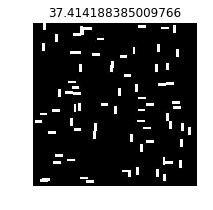

In [37]:
checkValidImage(200)

/home/jupyter/.fastai/data/project3/Valid/n_18_t_65_r_34_2745925605.jpg
True label: 18.0
Predicted label: 18.532506942749023


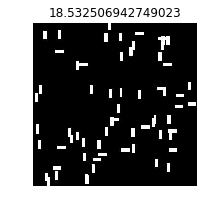

In [38]:
checkValidImage(300)

## Validation Performance

- Ovaral performance: MAE, RMSE, MSE
- Scatter plots
- Error distributions

In [39]:
predictions, actuals = learn.get_preds(ds_type=DatasetType.Valid)

In [40]:
predictions = np.transpose(np.array(predictions))[0]
actuals = np.array(actuals)

In [41]:
def assessment(predictions, actuals, dataset):
    ''' This function gives a summary of the performance on the given dataset'''
    
    print("Performance Assessment for "+dataset)
    print('MAE', mean_absolute_error(predictions, actuals))
    print('RMSE', np.sqrt(mean_squared_error(predictions, actuals)))
    print('MSE', mean_squared_error(predictions, actuals)) # validation metric
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(131)
    plt.scatter(x=actuals, y=predictions, s=2)
    plt.xlabel('actual')
    plt.ylabel('prediction')
    plt.title('Actual vs Prediction on '+dataset)
    plt.xlim([-1,51])
    plt.ylim([-1,51])
    plt.grid(True)

    errors = actuals-predictions

    plt.subplot(132)
    plt.scatter(x=actuals, y=errors, s=2)
    plt.xlabel('actual')
    plt.ylabel('error')
    plt.title('Actual vs Errors on '+dataset)
    plt.xlim([-1,51])
    plt.ylim([-10,10])
    plt.grid(True)

    rel_errors = errors/(actuals+0.0001)
              
    plt.subplot(133)
    plt.hist(rel_errors, bins=50, range=(-1,1))
    plt.xlabel('relative error')
    plt.ylabel('count')
    plt.title('Count of cases by Rel Errors on '+dataset)
    plt.grid(True)

    plt.show()
              
    abs_rel_errors = abs(rel_errors)
    
    print(100*np.round(np.mean(np.array(abs_rel_errors<0.05)),2),'% of images have relative error below 5%')
    print('50.0% of images have relative error below to', 100*np.round(np.quantile(abs_rel_errors,0.5),4),'%')
    print('95.0% of images have relative error below to', 100*np.round(np.quantile(abs_rel_errors,0.95),4),'%')


Performance Assessment for Valid Set
MAE 1.4110601
RMSE 1.8006489
MSE 3.2423368


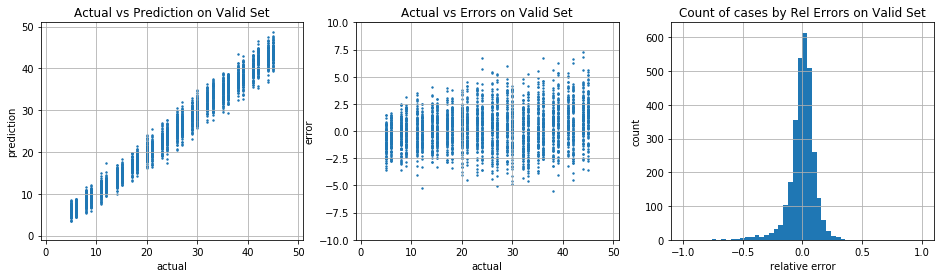

49.0 % of images have relative error below 5%
50.0% of images have relative error below to 5.17 %
95.0% of images have relative error below to 20.630000000000003 %


In [42]:
assessment(predictions, actuals, 'Valid Set')

### Valid set performance

There is a slight bias to under-estimate counts for the images with lower actual count, and over-estimate counts for images with larger actual count.

## Testing Performance

- Ovaral performance: MAE, RMSE
- Scatter plot
- Error distribution (histogram)

In [6]:
data = (ImageItemList.from_folder(path)
        .split_by_folder(train='Train', valid='Test')
        .label_from_func(get_ndots)
        .transform(bs=16)
        .databunch().normalize(imagenet_stats)
       )

In [7]:
learn = create_cnn(data, models.resnet18)

In [8]:
learn.load('counting')

Learner(data=ImageDataBunch;

Train: LabelList
y: FloatList (5880 items)
[FloatItem 32.0, FloatItem 17.0, FloatItem 15.0, FloatItem 23.0, FloatItem 42.0]...
Path: /home/jupyter/.fastai/data/project3
x: ImageItemList (5880 items)
[Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400)]...
Path: /home/jupyter/.fastai/data/project3;

Valid: LabelList
y: FloatList (7854 items)
[FloatItem 27.0, FloatItem 22.0, FloatItem 0.0, FloatItem 27.0, FloatItem 35.0]...
Path: /home/jupyter/.fastai/data/project3
x: ImageItemList (7854 items)
[Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400)]...
Path: /home/jupyter/.fastai/data/project3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(k

In [11]:
predictions, actuals = learn.get_preds(ds_type=DatasetType.Valid)

In [12]:
predictions = np.transpose(np.array(predictions))[0]
actuals = np.array(actuals)

Performance Assessment for Test Set
MAE 2.2751956
RMSE 3.287245
MSE 10.805981


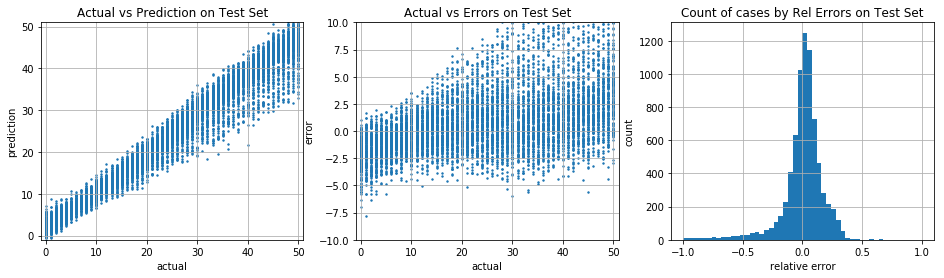

35.0 % of images have relative error below 5%
50.0% of images have relative error below to 7.68 %
95.0% of images have relative error below to 86.6 %


In [48]:
assessment(predictions, actuals, 'Test Set')

### Train set performance

Here the bias becomes a lot more noticeable. However, the Test set contains two kinds of images: those generated with image parameter values used for training, and those generated with new values for the image parameters. Next, we analyze the impact of the new values on the performance.

##### Distribution of Predictions in Test set.

Before that, it is interesting to look at the distribution of the predicted values, given that roughly only half of the values in the range 0-50 were not used in training. 

In the Test set, each of the 51 values used as a label is represented by 154 images. The following scatter plot shows the frequency with which each value from 0 to 50 gets targetted by the predictions. 

Note that some images get estimated counts below 0, and some above 50.

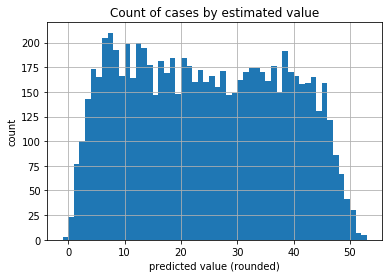

In [69]:
plt.hist([np.round(x) for x in predictions], bins=np.arange(-1,54))
plt.xlabel('predicted value (rounded)')
plt.ylabel('count')
plt.title('Count of cases by estimated value')
plt.grid(True)

## Analyze Performance on Test, only for known values of Image parameters.

Now we look at the performance on Test, but restricting the images to those generated with the same values used to generate the Train images.

In [50]:
files_paths = list(data.valid_ds.x.items)

In [51]:
predictions_sub = []
actuals_sub = []

for k,file_nm in enumerate(files_paths):
    file_nm = str(file_nm)
    if ((max([file_nm.find('n_'+str(x)+'_') for x in n_objs_DEV])>-1) and 
        (max([file_nm.find('t_'+str(x)+'_') for x in n_tots_DEV])>-1) and 
        (max([file_nm.find('r_'+str(x).replace('.','')+'_') for x in r_DEV])>-1)):
        predictions_sub.extend([predictions[k]])
        actuals_sub.extend([actuals[k]])

Performance Assessment for Test Set
MAE 1.4337081
RMSE 1.811548
MSE 3.2817063


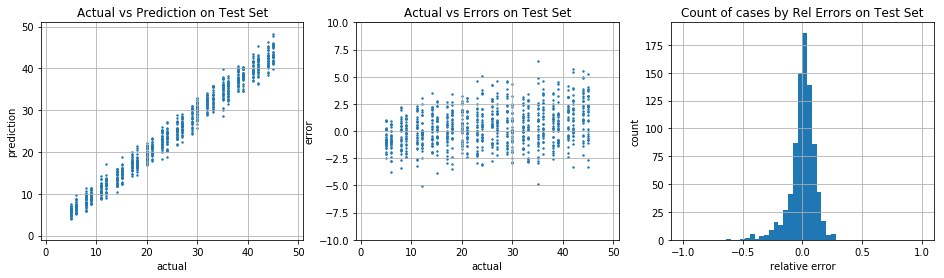

47.0 % of images have relative error below 5%
50.0% of images have relative error below to 5.510000000000001 %
95.0% of images have relative error below to 21.27 %


In [52]:
assessment(np.array(predictions_sub), np.array(actuals_sub), 'Test Set')

### The performance is almost identical to that obtained in Valid set. This is not surprising because Valid set was not used to train or select the model, simply to observe the performance. 

Next, we see what happens when we allow a single of the three image parameters to have new values, not used in the generation of the training images.

## Now analyze Test performance by allowing new values in one Image parameter at a time.

### New values for n_obj (while the others are known).

In [53]:
predictions_sub = []
actuals_sub = []

for k,file_nm in enumerate(files_paths):
    file_nm = str(file_nm)
    if ((max([file_nm.find('n_'+str(x)+'_') for x in n_objs_DEV])==-1) and 
        (max([file_nm.find('t_'+str(x)+'_') for x in n_tots_DEV])>-1) and 
        (max([file_nm.find('r_'+str(x).replace('.','')+'_') for x in r_DEV])>-1)):
        predictions_sub.extend([predictions[k]])
        actuals_sub.extend([actuals[k]])

Performance Assessment for Test Set
MAE 1.5685129
RMSE 2.0482457
MSE 4.1953106


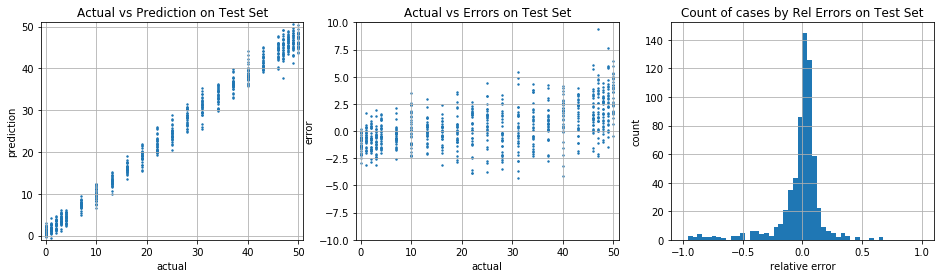

40.0 % of images have relative error below 5%
50.0% of images have relative error below to 6.39 %
95.0% of images have relative error below to 173.38 %


In [54]:
assessment(np.array(predictions_sub), np.array(actuals_sub), 'Test Set')

#### The performance is very good, the accuracy decreases a bit (although not with MAE), and the assessment is very similar to that of Test set for known values of image parameters. The relative error is large in some case due to the actual value being low (like 0 or 1), but this is expected.

#### This means that the CNN generalizes well to count horizontal rectangles in images with count values that were unknown during training. 

### New values for n_tot

In [55]:
predictions_sub = []
actuals_sub = []

for k,file_nm in enumerate(files_paths):
    file_nm = str(file_nm)
    if ((max([file_nm.find('n_'+str(x)+'_') for x in n_objs_DEV])>-1) and 
        (max([file_nm.find('t_'+str(x)+'_') for x in n_tots_DEV])==-1) and 
        (max([file_nm.find('r_'+str(x).replace('.','')+'_') for x in r_DEV])>-1)):
        predictions_sub.extend([predictions[k]])
        actuals_sub.extend([actuals[k]])

Performance Assessment for Test Set
MAE 1.4130223
RMSE 1.8010781
MSE 3.2438822


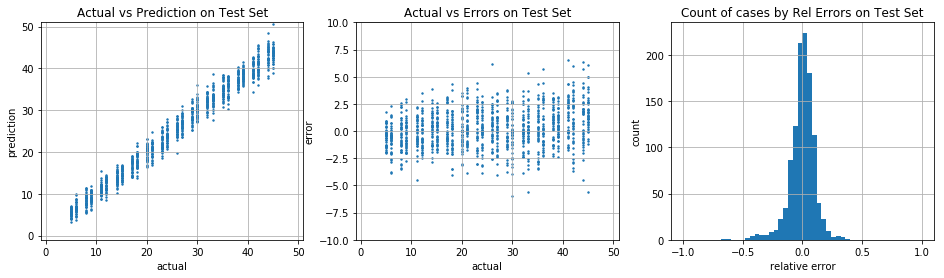

47.0 % of images have relative error below 5%
50.0% of images have relative error below to 5.52 %
95.0% of images have relative error below to 21.72 %


In [56]:
assessment(np.array(predictions_sub), np.array(actuals_sub), 'Test Set')

#### Good performance, so the CNN generalizes well to count horizontal rectangles when the image has a total number of rectangles that was not seen during training.

### New values for r

In [57]:
predictions_sub = []
actuals_sub = []

for k,file_nm in enumerate(files_paths):
    file_nm = str(file_nm)
    if ((max([file_nm.find('n_'+str(x)+'_') for x in n_objs_DEV])>-1) and 
        (max([file_nm.find('t_'+str(x)+'_') for x in n_tots_DEV])>-1) and 
        (max([file_nm.find('r_'+str(x).replace('.','')+'_') for x in r_DEV])==-1)):
        predictions_sub.extend([predictions[k]])
        actuals_sub.extend([actuals[k]])

Performance Assessment for Test Set
MAE 2.7558415
RMSE 3.8178854
MSE 14.576249


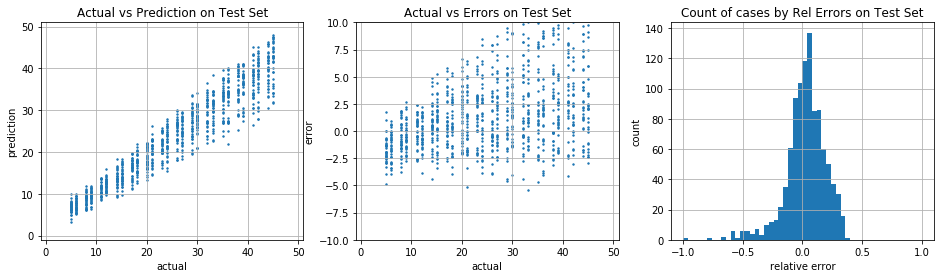

28.000000000000004 % of images have relative error below 5%
50.0% of images have relative error below to 9.34 %
95.0% of images have relative error below to 32.4 %


In [58]:
assessment(np.array(predictions_sub), np.array(actuals_sub), 'Test Set')

#### This is the parameter that has more impact in affecting the performance when the values have not been seen in training. 

#### Since the new values for the parameter are both below and above the known values, next we look at these two cases separately.

### New values for r, below the known values in training

In [59]:
predictions_sub = []
actuals_sub = []

for k,file_nm in enumerate(files_paths):
    file_nm = str(file_nm)
    if ((max([file_nm.find('n_'+str(x)+'_') for x in n_objs_DEV])>-1) and 
        (max([file_nm.find('t_'+str(x)+'_') for x in n_tots_DEV])>-1) and 
        (max([file_nm.find('r_'+str(x).replace('.','')+'_') for x in [2.0, 2.2, 2.4]])>-1)):
        predictions_sub.extend([predictions[k]])
        actuals_sub.extend([actuals[k]])

Performance Assessment for Test Set
MAE 3.8727028
RMSE 5.007087
MSE 25.07092


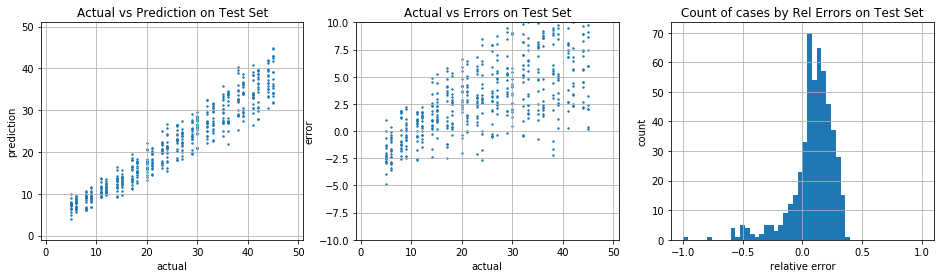

15.0 % of images have relative error below 5%
50.0% of images have relative error below to 14.19 %
95.0% of images have relative error below to 34.21 %


In [60]:
assessment(np.array(predictions_sub), np.array(actuals_sub), 'Test Set')

#### Here it is evident that the new values for r, lower than those used in training, that is, smaller rectangles, have a negative impact on the performance. The predictions are under-estimations of the actual values, which is probably due to the fact that part of the ability of the CNN to estimate counts is due to the number of white pixels. 

### New values for r, above the known values in training

In [61]:
predictions_sub = []
actuals_sub = []

for k,file_nm in enumerate(files_paths):
    file_nm = str(file_nm)
    if ((max([file_nm.find('n_'+str(x)+'_') for x in n_objs_DEV])>-1) and 
        (max([file_nm.find('t_'+str(x)+'_') for x in n_tots_DEV])>-1) and 
        (max([file_nm.find('r_'+str(x).replace('.','')+'_') for x in [3.6, 3.8, 4.0]])>-1)):
        predictions_sub.extend([predictions[k]])
        actuals_sub.extend([actuals[k]])

Performance Assessment for Test Set
MAE 1.6389799
RMSE 2.0202909
MSE 4.081575


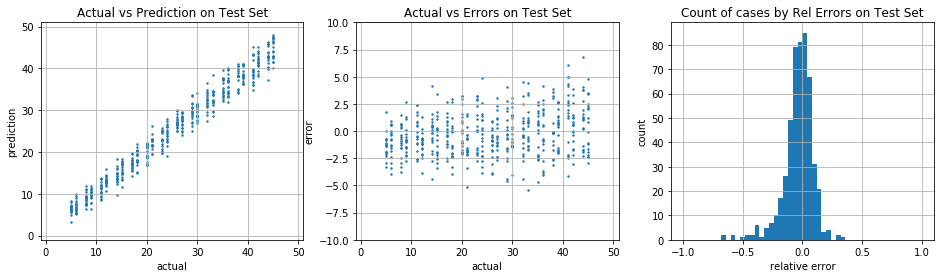

41.0 % of images have relative error below 5%
50.0% of images have relative error below to 6.260000000000001 %
95.0% of images have relative error below to 26.43 %


In [62]:
assessment(np.array(predictions_sub), np.array(actuals_sub), 'Test Set')

#### But here again we see very good performance, when the values of r are larger than those used for training. This means that the impact of the raw amount of white pixels in the count estimation is not that important, otherwise we would observe here an over-estimation of the actual count. It could happen as well that the rectangles being larger, causes more overlap between them, and therefore fewer white pixels than what the increased r would imply with non-overlapping rectangles.

#### Finally, to test the impact of r in the estimation, we look at the average estimations for each value of r, as we increase it.

In [9]:
files_paths = list(data.valid_ds.x.items)

In [15]:
rs = [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]
avg_preds = []
for r in rs:
    predictions_sub = []
    actuals_sub = []

    for k,file_nm in enumerate(files_paths):
        file_nm = str(file_nm)
        if (max([file_nm.find('r_'+str(x).replace('.','')+'_') for x in [r]])>-1):
            predictions_sub.extend([predictions[k]])
            actuals_sub.extend([actuals[k]])
    
    avg_preds.extend([np.mean(np.array(predictions_sub))])

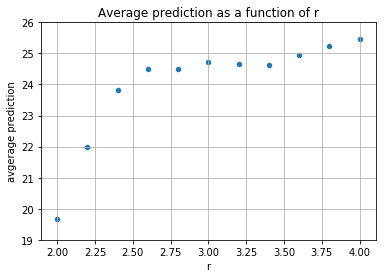

In [21]:
plt.scatter(x=rs, y=avg_preds, s=20)
plt.xlabel('r')
plt.ylabel('avgerage prediction')
plt.title('Average prediction as a function of r')
plt.ylim([19,26])
plt.grid(True)

#### We observe then that  while r increases within the training range (2.5, 3.5), the average prediction remains fairly constant. However, it is for values outside the range used for training that the count estimation behaves monotonically increasing (as if the counting were a function of the number of white pixels). In other words, the counting is not a function of white pixels as long as the dimensions of the rectangles are within the training range, which is a limitation of the CNN's capacity to generalize well outside the training parameters. 

### Count estimation as a function of r

#### The above scatter plot shows the average estimated count (over all images) for each value of r. However, each of the images over which the average was taken had different number counts. Next, we look at once configuration of the 30 rectangles, and only change the value of r, and observe the estimation of the count.

In [3]:
def manyImageSameLocations(n_dots, n_tot, r_min, r_max, m):
    ''' This function creates m images, each with an r between r_min and r_max, all with the same rectangles.'''
    sz = 400
    margin = 5

    xs = np.random.uniform(margin, sz-margin, n_tot)
    ys = np.random.uniform(margin, sz-margin, n_tot)

    for r in np.linspace(r_min, r_max, m):
    
        r = np.round(r,4)
        img = Image.new(mode='RGB', size=(sz, sz))
        draw = ImageDraw.Draw(img)

        for k in range(n_dots):
            draw.rectangle((xs[k]-3*r, ys[k]-r, xs[k]+3*r, ys[k]+r), fill=(255, 255, 255))
        for k in np.arange(n_dots, n_tot):
            draw.rectangle((xs[k]-r, ys[k]-3*r, xs[k]+r, ys[k]+3*r), fill=(255, 255, 255))

        suff = (str(xs[0])[0:6]+str(ys[0])[0:6]).replace('.','')
        file_nm = 'n_'+str(n_dots)+'_t_'+str(n_tot)+'_r_'+str(r).replace('.','p')+'__'+suff+'.jpg' 

        img.save(path/('tmp/'+file_nm)) 

In [77]:
n_dots = 20
n_tot = 65
r_min = 1.0
r_max = 6.0
m = 101

In [78]:
manyImageSameLocations(n_dots, n_tot, r_min, r_max, m)

In [6]:
data = (ImageItemList.from_folder(path)
        .split_by_folder(train='Train', valid='tmp')
        .label_from_func(get_ndots)
        .transform(bs=16)
        .databunch().normalize(imagenet_stats)
       )

learn = create_cnn(data, models.resnet18)

learn.load('counting')

Learner(data=ImageDataBunch;

Train: LabelList
y: FloatList (5880 items)
[FloatItem 32.0, FloatItem 17.0, FloatItem 15.0, FloatItem 23.0, FloatItem 42.0]...
Path: /home/jupyter/.fastai/data/project3
x: ImageItemList (5880 items)
[Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400)]...
Path: /home/jupyter/.fastai/data/project3;

Valid: LabelList
y: FloatList (101 items)
[FloatItem 20.0, FloatItem 20.0, FloatItem 20.0, FloatItem 20.0, FloatItem 20.0]...
Path: /home/jupyter/.fastai/data/project3
x: ImageItemList (101 items)
[Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400), Image (3, 400, 400)]...
Path: /home/jupyter/.fastai/data/project3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(ke

In [7]:
predictions, actuals = learn.get_preds(ds_type=DatasetType.Valid)

In [8]:
predictions = np.transpose(np.array(predictions))[0]
actuals = np.array(actuals)

In [9]:
files_paths = list(data.valid_ds.x.items)
rs = [float(str(s)[str(s).find("_r_")+3:str(s).find("__")].replace('p','.')) for s in files_paths]

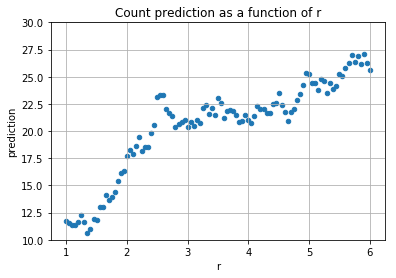

In [10]:
plt.scatter(x=rs, y=predictions, s=20)
plt.xlabel('r')
plt.ylabel('prediction')
plt.title('Count prediction as a function of r')
plt.ylim([10,30])
plt.grid(True)

#### Consistent with what was found above, the estimated count is stable in a narrow range for values of r in the range used for training: [2.6, 3.4]. But outside of it, the behavior shows monotonicity, specially below 2.6.